In [54]:
import numpy, scipy, matplotlib.pyplot as plt, pandas as pd
import sklearn, IPython.display as ipd
import librosa, librosa.display

from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path
%matplotlib inline

## Step 1: Retrieve Audio

In [2]:
# c1_signals = []
# counter=0
# for p in Path().glob('audio/train/c1/*.mp3'):
#     counter=counter+1
#     if counter > 10:
#         break
#     else:
#         c1_signals.append(librosa.load(p, duration=30, offset=10)[0])

In [3]:
# c2_signals = []
# counter=0
# for p in Path().glob('audio/train/c2/*.mp3'):
#     counter=counter+1
#     if counter > 10:
#         break
#     else:
#         c2_signals.append(librosa.load(p, duration=30, offset=10)[0])

In [4]:
c1_signals = [
    librosa.load(p, duration=30, offset=10)[0] for p in Path().glob('audio/train/c1/*.mp3')
]
c2_signals = [
    librosa.load(p, duration=30, offset=10)[0] for p in Path().glob('audio/train/c2/*.mp3')
]

In [5]:
print(len(c1_signals))
print(len(c2_signals))

100
100


## Step 2: Extract Features

In [6]:
n_mfcc = 12
hop_length = 512
def extract_features(signal):
    return [
        librosa.feature.zero_crossing_rate(signal)[0, 0],
        librosa.feature.spectral_centroid(signal)[0, 0],
        librosa.feature.mfcc(signal, n_mfcc=n_mfcc).T[0, 0],
        librosa.feature.melspectrogram(signal)[0, 0],
        librosa.feature.tempogram(signal, hop_length=hop_length)[0,0]
    ]

In [7]:
c1_features = numpy.array([extract_features(x) for x in c1_signals])
c2_features = numpy.array([extract_features(x) for x in c2_signals])

/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_agg[idx_agg] = aggregate(data[idx_in], axis=axis)
/home/kameswar/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tu

In [8]:
print(c1_features.shape)
print(c2_features.shape)

(100, 5)
(100, 5)


Text(0,0.5,'Count')

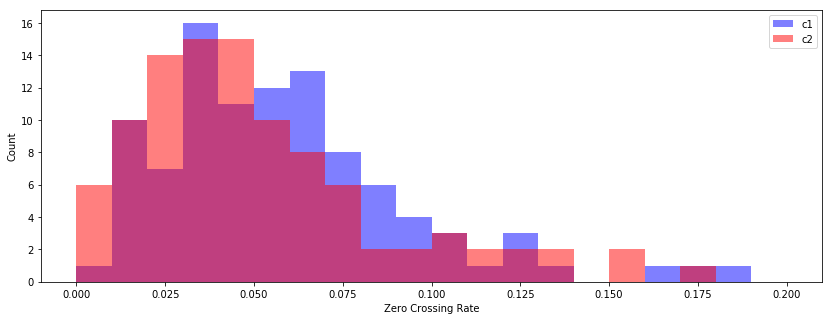

In [9]:
plt.figure(figsize=(14, 5))
plt.hist(c1_features[:,0], color='b', range=(0, 0.2), alpha=0.5, bins=20)
plt.hist(c2_features[:,0], color='r', range=(0, 0.2), alpha=0.5, bins=20)
plt.legend(('c1', 'c2'))
plt.xlabel('Zero Crossing Rate')
plt.ylabel('Count')

Text(0,0.5,'Count')

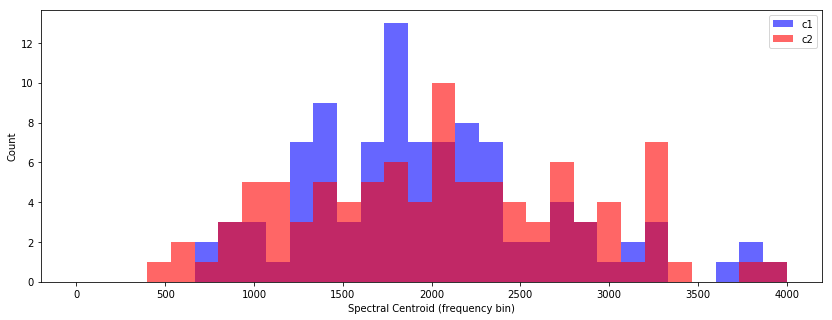

In [10]:
plt.figure(figsize=(14, 5))
plt.hist(c1_features[:,1], color='b', range=(0, 4000), bins=30, alpha=0.6)
plt.hist(c2_features[:,1], color='r', range=(0, 4000), bins=30, alpha=0.6)
plt.legend(('c1', 'c2'))
plt.xlabel('Spectral Centroid (frequency bin)')
plt.ylabel('Count')

## Step 3: Train the Classifier

In [11]:
#scaler = sklearn.preprocessing.StandardScaler()
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))

c1_features_scaled = scaler.fit_transform(c1_features)
print(c1_features_scaled.mean(axis=0))
print(c1_features_scaled.std(axis=0))

c2_features_scaled = scaler.transform(c2_features)
print(c2_features_scaled.mean(axis=0))
print(c2_features_scaled.std(axis=0))

[-0.48218527 -0.56117853  0.36229667 -0.88465501 -1.        ]
[0.37087445 0.28193247 0.33972728 0.3208449  0.        ]
[-0.57083135 -0.52069377  0.14236413 -0.30747734 -1.        ]
[0.3494818  0.32516196 0.33205881 2.71901158 0.        ]


In [12]:
train_features = numpy.vstack((c1_features_scaled, c2_features_scaled))
print(train_features.shape)
print(train_features.min(axis=0))
print(train_features.max(axis=0))

(200, 5)
[-1.03325416 -1.07035774 -1.         -1.0000003  -1.        ]
[ 1.          1.          1.         18.72032157 -1.        ]


In [13]:
train_labels = numpy.concatenate((numpy.zeros(len(c1_features_scaled)), numpy.ones(len(c2_features_scaled))))

In [14]:
print(train_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


In [65]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = sklearn.svm.SVC()
model = GridSearchCV(svc, parameters)

In [62]:
# parameters = {'weights':('uniform', 'distance'), 'n_neighbors':[1, 3, 5, 7]}
# knn = sklearn.neighbors.KNeighborsClassifier()
# model = GridSearchCV(knn, parameters)

In [60]:
#model = sklearn.svm.SVC()
#model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=5)
#model = sklearn.linear_model.LogisticRegression()
#model = sklearn.tree.DecisionTreeClassifier()
#model = sklearn.naive_bayes.GaussianNB()

In [66]:
acc  = sklearn.model_selection.cross_val_score(model, train_features, train_labels, cv=10)

In [67]:
print('acc =', acc)
print ('acc mean =',acc.mean())

acc = [0.8  0.65 0.7  0.65 0.8  0.7  0.7  0.65 0.7  0.75]
acc mean = 0.7100000000000001


In [21]:
model.fit(train_features, train_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

## Step 4: Run the Classifier

In [22]:
# c1_test_signals = []
# counter=0
# for p in Path().glob('audio/test/c1/*.mp3'):
#     counter=counter+1
#     if counter > 2:
#         break
#     else:
#         c1_test_signals.append(librosa.load(p, duration=30, offset=60)[0])

In [23]:
# c2_test_signals = []
# counter=0
# for p in Path().glob('audio/test/c2/*.mp3'):
#     counter=counter+1
#     if counter > 2:
#         break
#     else:
#         c2_test_signals.append(librosa.load(p, duration=30, offset=60)[0])

In [24]:
c1_test_signals = [
    librosa.load(p, duration=30, offset=60)[0] for p in Path().glob('audio/test/c1/*.mp3')
]
c2_test_signals = [
    librosa.load(p, duration=30, offset=60)[0] for p in Path().glob('audio/test/c2/*.mp3')
]

In [25]:
print(len(c1_test_signals))
print(len(c2_test_signals))

25
25


In [26]:
c1_test_features = numpy.array([extract_features(x) for x in c1_test_signals])
c2_test_features = numpy.array([extract_features(x) for x in c2_test_signals])

/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/core/audio.py:574: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.pad((y_sign[slice_post] != y_sign[slice_pre]),
/home/kameswar/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1377: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  data_agg[idx_agg] = aggregate(data[idx_in], axis=axis)
/home/kameswar/anaconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tu

In [27]:
print(c1_test_features.shape)
print(c2_test_features.shape)

(25, 5)
(25, 5)


In [28]:
c1_test_features_scaled = scaler.transform(c1_test_features)
c2_test_features_scaled = scaler.transform(c2_test_features)

In [29]:
test_features = numpy.vstack((c1_test_features_scaled, c2_test_features_scaled))

In [30]:
test_labels = numpy.concatenate((numpy.zeros(len(c1_test_features)), numpy.ones(len(c2_test_features))))

In [31]:
print(test_labels)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]


In [32]:
predicted_labels = model.predict(test_features)

In [33]:
predicted_labels

array([0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.])

## Step 5: Evaluation

In [34]:
score = model.score(test_features, test_labels)
roc_auc = roc_auc_score(test_labels, predicted_labels)
recall = recall_score(test_labels, predicted_labels)
precision = precision_score(test_labels, predicted_labels)
fmeasure = f1_score(test_labels, predicted_labels)
r2 = r2_score(test_labels, predicted_labels)

In [35]:
tp = sum((test_labels == 1) & (predicted_labels == 1))
tn = sum((test_labels == 0) & (predicted_labels == 0))
fp = sum((test_labels == 0) & (predicted_labels == 1))
fn = sum((test_labels == 1) & (predicted_labels == 0))
print (tp, tn, fp, fn)

16 17 8 9


In [36]:
results = [score, roc_auc, recall, precision, fmeasure, r2]
result_labels = ['accuracy', 'roc_auc', 'recall', 'precision', 'fmeasure', 'r2_score']

In [37]:
pd.DataFrame(results, result_labels)

,0
accuracy,0.660000
roc_auc,0.660000
recall,0.640000
precision,0.666667
fmeasure,0.653061
r2_score,-0.360000
